In [1]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import numpy as np
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from torch import nn, optim
from torch.nn import functional as F
from tqdm.notebook import tqdm

In [2]:
@dataclass
class CisConfig:
    n_instances: int = 1
    n_feat: int = 2
    n_hidden: int = 4
    act_fn: List[Callable] = field(default_factory=lambda: [F.relu, F.relu])
    #b1: str | Float[t.Tensor, "inst hid"] = field(default_factory=lambda: "0")
    #b2: str | Float[t.Tensor, "inst hid"] = field(default_factory=lambda: "0")
    optimizer: Callable = t.optim.Adam
    fx: Callable = F.relu

    def __post_init__(self):
        """Ensure attribute values are valid."""
        pass

In [416]:
class Lucius(nn.Module):
    """Lucius toy model."""

    W1: Float[t.Tensor, "inst feat hid"]
    W2: Float[t.Tensor, "inst hid feat"]

    def __init__(self, cfg: CisConfig):
        """Initializes model params."""
        super().__init__()
        self.cfg = cfg

        # Model Weights
        self.W1 = nn.Parameter(nn.init.xavier_normal_(t.empty(cfg.n_instances, cfg.n_feat, cfg.n_hidden)))
        self.W2 = nn.Parameter(nn.init.xavier_normal_(t.empty(cfg.n_instances, cfg.n_hidden, cfg.n_feat)))    

    def gen_batch(self, batch_sz: int) -> t.Tensor:
        """Generates a batch of data (sparse feature vals on [-1, 1]) with instances.
        
        Returns:
            Tensor of shape (batch_sz, n_instances, n_feat) with one random activated
            feature per instance.
        """
        # Create zero tensor with instances dimension
        x = t.zeros(batch_sz, self.cfg.n_instances, self.cfg.n_feat)
        
        # Generate random positions for each batch and instance
        active_positions = t.randint(0, self.cfg.n_feat, (batch_sz, self.cfg.n_instances))
        
        # Generate random values between -1 and 1 for each batch and instance
        #active_values = t.rand(batch_sz, self.cfg.n_instances) * 2 - 1
        active_values = t.randint(0, 2, (batch_sz, self.cfg.n_instances)) * 2.0 - 1
        
        # Create index tensors for vectorized assignment
        batch_idx = t.arange(batch_sz).view(-1, 1).expand(-1, self.cfg.n_instances)
        instance_idx = t.arange(self.cfg.n_instances).expand(batch_sz, -1)
        
        # Vectorized assignment using advanced indexing
        x[batch_idx, instance_idx, active_positions] = active_values
        
        return x

    def forward(self, x: Float[t.Tensor, "batch inst feat"]) -> Float[t.Tensor, "batch inst feat"]:
        """Runs a forward pass through model returning the loss."""

        # Hidden layer
        h = einsum(x, self.W1, "batch inst feat, inst feat hid -> batch inst hid")
        h = self.cfg.act_fn[0](h)

        # Output layer
        y = einsum(h, self.W2, "batch inst hid, inst hid feat -> batch inst feat")
        #y = self.cfg.act_fn[1](y + self.b2)
        #y = self.cfg.act_fn[0](y)

        return y

    def calculate_loss(self,  x: Float[t.Tensor, "batch inst feat"], y: Float[t.Tensor, "batch inst feat"]) -> Float[t.Tensor, ""]:

        y_true = self.cfg.fx(x)
        #return self.weighted_L1(y_true, y)
        #return self.zero_out_inactive(y_true, y)
    
        non_zero_mask = (x != 0)
        zero_mask = (x == 0)
        
        y_diff = y[non_zero_mask] - y_true[non_zero_mask]
        
        loss = t.mean(t.abs(y_diff))
        rest_mult = 2.0
        loss += rest_mult * t.mean(t.abs(y[zero_mask] - y_true[zero_mask]))
        return loss
    
    # def weighted_binary_cross_entropy(self, y_true, y_pred, active_weight=10.0, inactive_weight=1.0):
    #     # print(y_true.shape)
    #     # print(y_pred.shape)
    #     # print(t.min(y_true), t.max(y_true))
    #     # print(t.min(y_pred), t.max(y_pred))
    #     weights = t.where(y_true == 1, active_weight, inactive_weight)
    #     y_pred_sigmoid = t.sigmoid(y_pred)
    #     bce = F.binary_cross_entropy(y_pred_sigmoid, y_true, reduction='none')
    #     weighted_bce = weights * bce
    #     return t.mean(weighted_bce)
    
    # def zero_out_inactive(self, y_true, y_pred):
    #     thres = 0.01
    #     relative_thres = thres * y_true
    #     cleaned_pred = t.relu(y_pred - relative_thres) + relative_thres
    #     mse = (y_true - cleaned_pred) ** 2
    #     return t.mean(mse)

    def weighted_mse(self, y_true, y_pred, active_weight=100, inactive_weight=1.0):
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        mse = (y_true - y_pred) ** 2
        weighted_mse = weights * mse
        return t.mean(weighted_mse)

    def weighted_L1(self, y_true, y_pred, active_weight=10, inactive_weight=1.0):
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        L1 = t.abs(y_true - y_pred)
        weighted_L1 = weights * L1
        return t.mean(weighted_L1)

    def optimize(
        self, optimizer: t.optim.Optimizer, batch_sz: int, steps: int, logging_freq: int
    ):
        """Optimizes the model."""

        losses = []
        pbar = tqdm(range(steps), desc="Training")

        for step in pbar:
            x = self.gen_batch(batch_sz)
            y = self.forward(x)
            optimizer.zero_grad()
            loss = self.calculate_loss(x, y)
            loss.backward()
            optimizer.step()
            # Log progress
            if step % logging_freq == 0 or (step + 1 == steps):
                losses.append(loss.item())
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})
            # if loss <= 10e-4:
            #     print(loss)
            #     break

        return losses

In [463]:
n_instances=1
n_feat = 100
n_hidden = 50

config = CisConfig(n_instances=n_instances, n_feat=n_feat, n_hidden=n_hidden)

In [464]:
model = Lucius(config)
batch_sz = 128
steps = 10000
logging_freq = steps // 10

model.optimize(t.optim.Adam(model.parameters()), batch_sz, steps, logging_freq)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.5739222764968872,
 0.06184816360473633,
 0.04775070399045944,
 0.04032653942704201,
 0.03730395436286926,
 0.029415776953101158,
 0.023491378873586655,
 0.027341339737176895,
 0.019249679520726204,
 0.020845361053943634,
 0.02053186483681202]

100
[tensor(0.0269), tensor(0.0453), tensor(0.0582), tensor(0.0241), tensor(0.0221), tensor(0.0465), tensor(0.0509), tensor(0.0273), tensor(0.0452), tensor(0.0369), tensor(0.0273), tensor(0.0528), tensor(0.0114), tensor(0.0434), tensor(0.0263), tensor(0.0453), tensor(0.0438), tensor(0.0466), tensor(0.0264), tensor(0.0338), tensor(0.0452), tensor(0.0377), tensor(0.0548), tensor(0.0616), tensor(0.0276), tensor(0.0386), tensor(0.0603), tensor(0.0472), tensor(0.0561), tensor(0.0271), tensor(0.0402), tensor(0.0368), tensor(0.0261), tensor(0.0269), tensor(0.0361), tensor(0.0390), tensor(0.0517), tensor(0.0400), tensor(0.0391), tensor(0.0547), tensor(0.0419), tensor(0.0344), tensor(0.0283), tensor(0.0441), tensor(0.0335), tensor(0.0231), tensor(0.0494), tensor(0.0418), tensor(0.0518), tensor(0.0471), tensor(0.0250), tensor(0.0397), tensor(0.0431), tensor(0.0262), tensor(0.0525), tensor(0.0175), tensor(0.0593), tensor(0.0387), tensor(0.0280), tensor(0.0353), tensor(0.0381), tensor(0.0493), ten

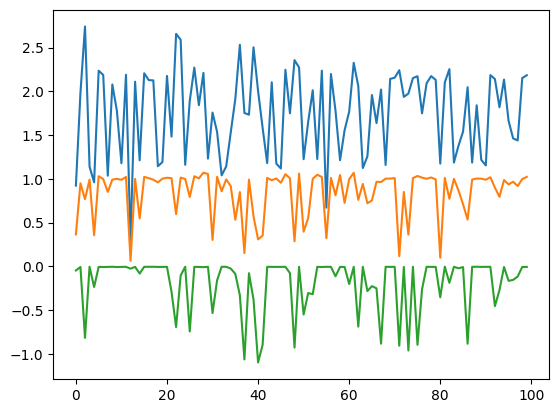

In [576]:
count, losses_sep, losses_stat = count_represented_features(n_feat, model, threshold=0.1)
print(count)
print(losses_sep)
print(losses_stat)
sums = [losses_stat[i][3] for i in range(n_feat)]
maxs = [losses_stat[i][0] for i in range(n_feat)]
mins = [losses_stat[i][1] for i in range(n_feat)]
big_noise = [losses_stat[i][2] for i in range(n_feat)]
plt.plot(sums)
plt.plot(maxs)
plt.plot(mins)
print(big_noise)
#print(np.mean(losses_sep))

C:\Users\gigle\AppData\Local\Temp\ipykernel_22168\3214739401.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


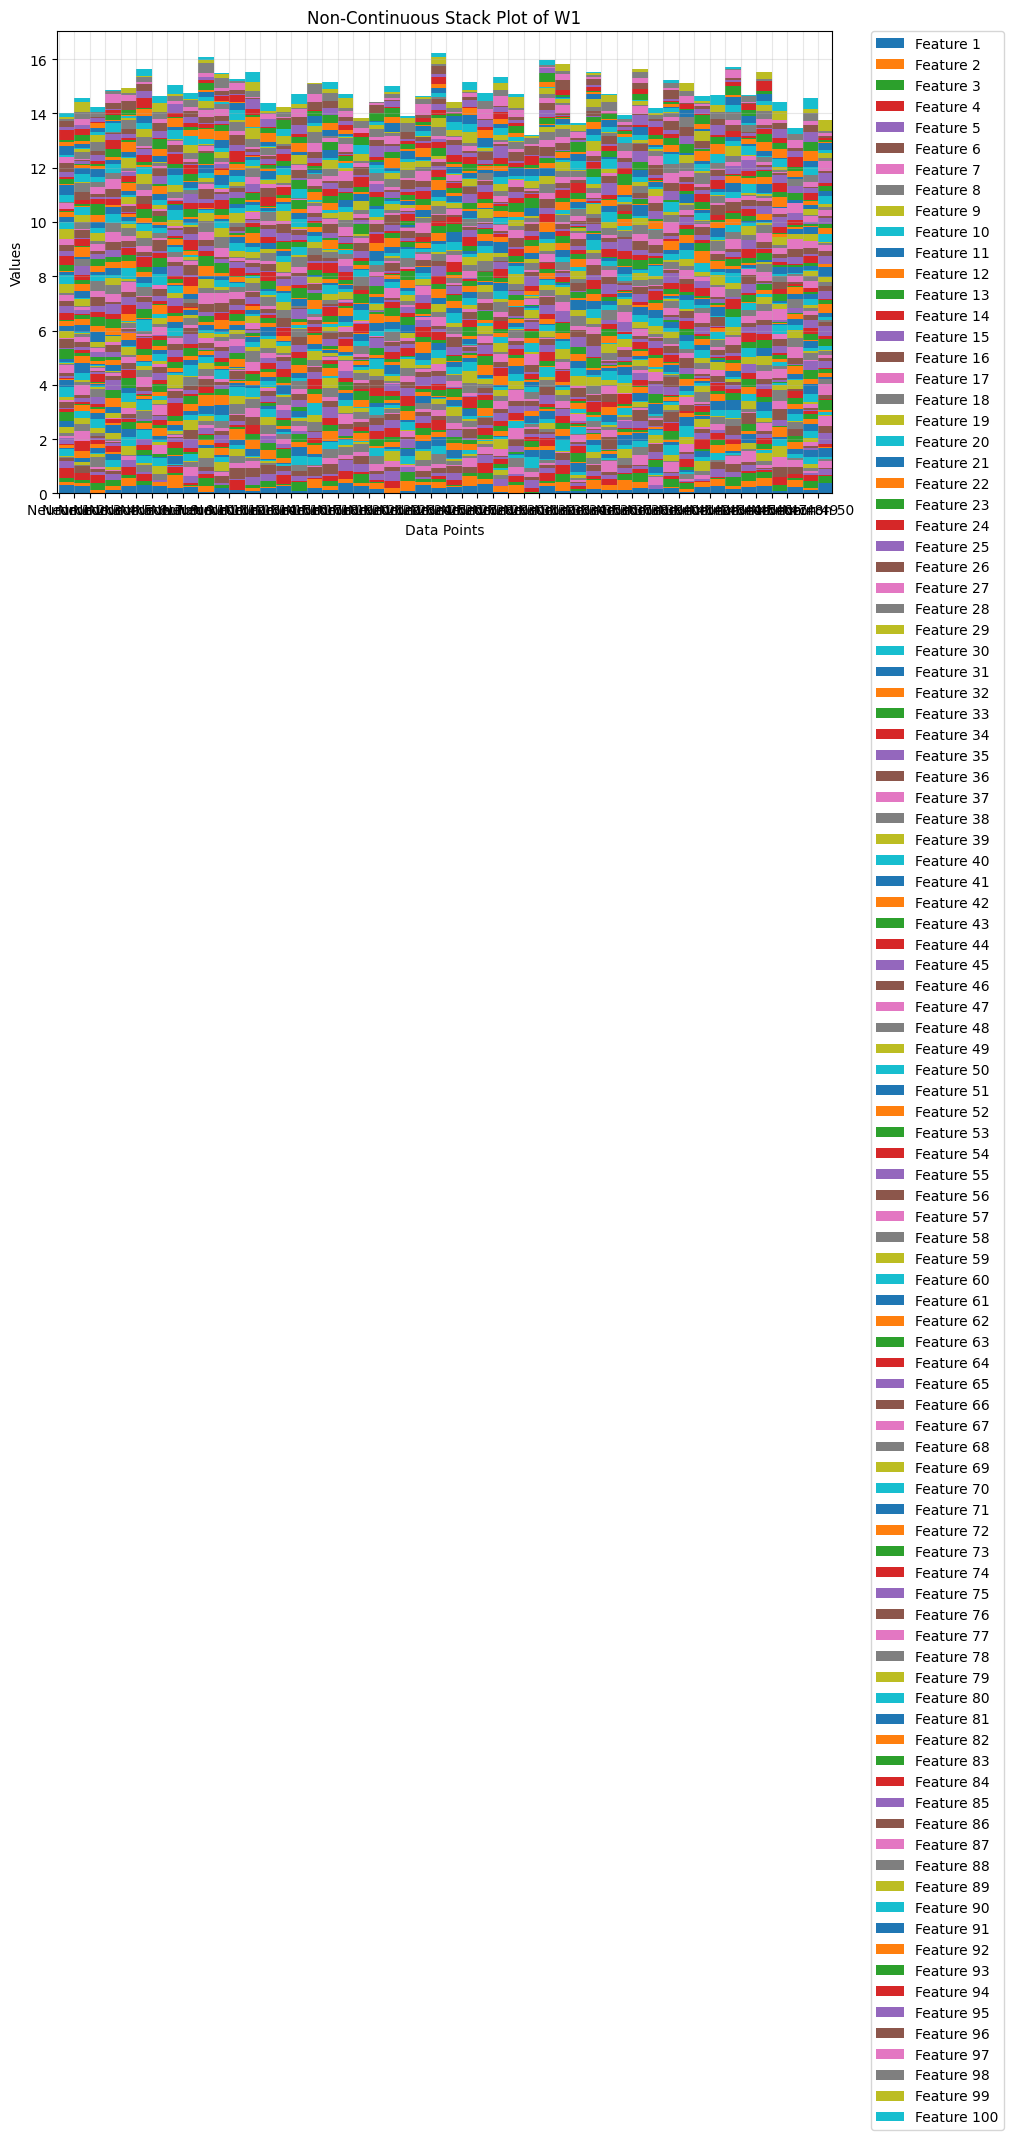

In [491]:
plot_polysemanticity(model.W1.detach().squeeze(), transpose=False)

In [479]:
W1 = model.W1[0].detach().squeeze().clone()
W2 = model.W2[0].detach().squeeze().clone()


In [507]:
positives = [sum([W1[j,i]*W2[i][j] for i in range(n_hidden) if W2[i][j] > 0]) for j in range(n_feat)]
negatives = [sum([W1[j,i]*W2[i][j] for i in range(n_hidden) if W2[i][j] < 0]) for j in range(n_feat)]
sums = [positives[i] + negatives[i] for i in range(n_feat)]
print(sums)

[tensor(1.0082), tensor(1.0054), tensor(0.9972), tensor(1.0011), tensor(0.9973), tensor(0.9987), tensor(1.0067), tensor(0.9936), tensor(0.9968), tensor(1.0010), tensor(1.0035), tensor(1.0086), tensor(0.9944), tensor(0.9992), tensor(0.9982), tensor(0.9993), tensor(1.0008), tensor(1.0037), tensor(1.0033), tensor(0.9903), tensor(0.9988), tensor(0.9922), tensor(0.9988), tensor(0.9907), tensor(0.9958), tensor(0.9997), tensor(0.9856), tensor(1.0101), tensor(1.0114), tensor(0.9978), tensor(0.9953), tensor(0.9942), tensor(0.9949), tensor(0.9962), tensor(0.9948), tensor(1.0004), tensor(1.0005), tensor(0.9957), tensor(1.0041), tensor(1.0041), tensor(0.9985), tensor(0.9975), tensor(1.0045), tensor(0.9984), tensor(0.9902), tensor(1.0005), tensor(0.9959), tensor(0.9936), tensor(0.9958), tensor(1.0012), tensor(0.9998), tensor(1.0064), tensor(1.0025), tensor(1.0014), tensor(0.9927), tensor(0.9961), tensor(1.0149), tensor(0.9973), tensor(0.9965), tensor(0.9961), tensor(0.9976), tensor(1.0023), tensor(

tensor(0.9213)


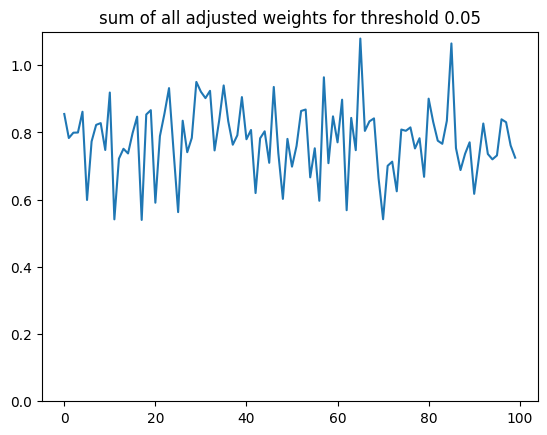

In [564]:
thr = 0.01
counts = [sum([W1_adj[i][j] for j in range(n_hidden) if abs(W1_adj[i][j]) > thr]) for i in range(n_feat)]
plt.plot(counts)
plt.ylim(0,1.1)
plt.title(f"sum of all adjusted weights for threshold {thr}")
print(counts[30])

tensor(-12.3735)
tensor(112.3403)


C:\Users\gigle\AppData\Local\Temp\ipykernel_22168\3936854197.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


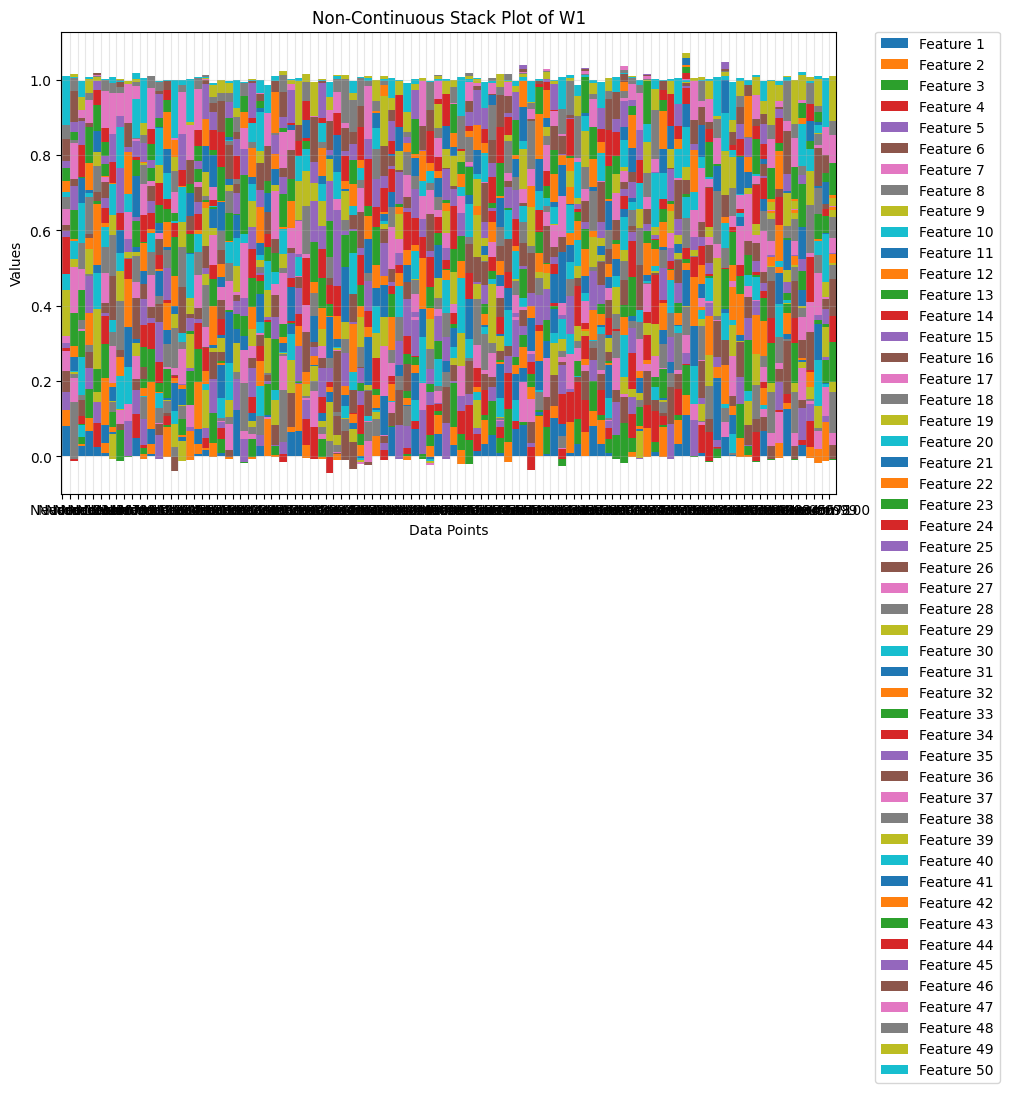

In [518]:

print(t.sum(W1_adj[W1_adj < 0]))
print(t.sum(W1_adj[W1_adj > 0]))
plot_polysemanticity(W1_adj, transpose=True, do_thres=False)


(tensor([24, 21, 19, 19, 20, 19, 18, 18, 15, 24, 22, 21, 24, 18, 24, 17, 19, 21,
        23, 22, 22, 20, 21, 16, 23, 24, 17, 19, 20, 20, 19, 18, 18, 23, 23, 17,
        23, 20, 20, 19, 21, 19, 22, 20, 24, 22, 14, 20, 25, 19, 22, 20, 23, 22,
        21, 21, 22, 23, 22, 20, 23, 19, 23, 20, 21, 19, 22, 20, 18, 22, 22, 22,
        23, 25, 19, 19, 21, 18, 19, 22, 20, 15, 22, 18, 18, 20, 21, 21, 19, 18,
        24, 19, 21, 18, 18, 22, 18, 23, 19, 19]), tensor([38, 39, 37, 40, 42, 44, 38, 41, 39, 38, 39, 48, 44, 37, 40, 42, 41, 41,
        39, 34, 43, 42, 38, 43, 47, 42, 44, 40, 44, 37, 36, 50, 43, 35, 45, 41,
        33, 43, 36, 38, 44, 37, 41, 46, 43, 47, 42, 48, 41, 32]))


C:\Users\gigle\AppData\Local\Temp\ipykernel_22168\1789981458.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


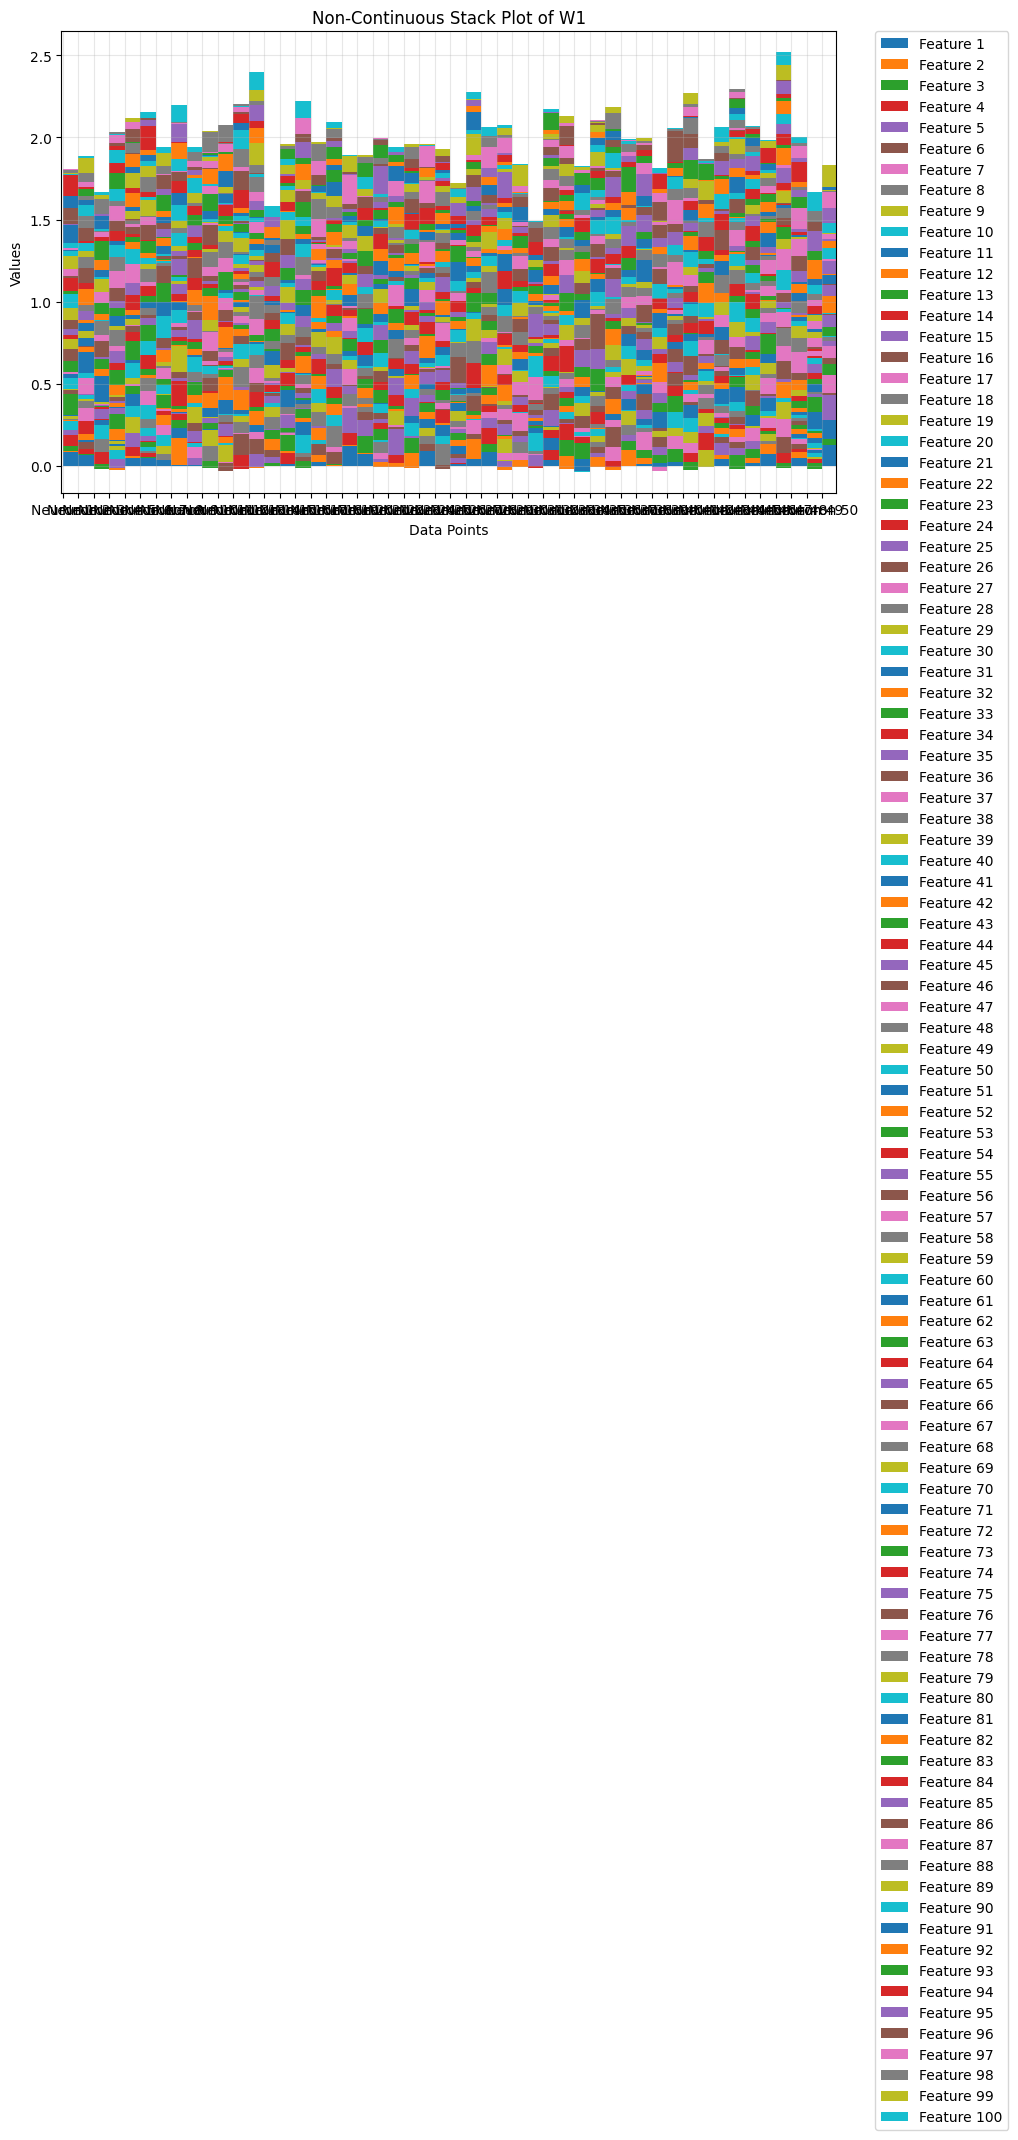

In [495]:
#W1 = model.W1[0].detach().squeeze()
    
def count_above_threshold(matrix, threshold):
    row_counts = (matrix > threshold).sum(dim=1)
    col_counts = (matrix > threshold).sum(dim=0)
    return row_counts, col_counts

#W2 = model.W2[0].detach().squeeze()
#print(count_above_threshold(W1, 0.01))
W1_adj = t.empty_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        #print(i,j)
        W1_adj[i][j] = W1[i][j] * W2[j][i]

#print(W1_adj.shape)
print(count_above_threshold(W1_adj,0.01))
#print(W1.shape, W2.shape)
plot_polysemanticity(W1_adj, do_thres = False)

In [357]:
print(model.W1)
print(model.W2)

Parameter containing:
tensor([[[0.0302, 0.2459, 0.0021,  ..., 0.1554, 0.0191, 0.3434],
         [0.1354, 0.2551, 0.0250,  ..., 0.0794, 0.2639, 0.2254],
         [0.0025, 0.1856, 0.1041,  ..., 0.0804, 0.0255, 0.0515],
         ...,
         [0.0028, 0.2065, 0.1037,  ..., 0.2849, 0.2756, 0.0037],
         [0.0684, 0.0619, 0.0143,  ..., 0.3325, 0.0154, 0.0204],
         [0.0717, 0.0628, 0.0150,  ..., 0.3363, 0.0161, 0.0211]]],
       requires_grad=True)
Parameter containing:
tensor([[[-0.2152, -0.0785, -0.3384,  ..., -0.2043, -0.0709, -0.0691],
         [ 0.1715,  0.1804,  0.0925,  ...,  0.1054, -0.0741, -0.0730],
         [-0.1998, -0.1723, -0.0216,  ..., -0.0150, -0.1971, -0.1943],
         ...,
         [ 0.0914, -0.2277, -0.1017,  ...,  0.1532,  0.2802,  0.2768],
         [-0.1971,  0.1063, -0.1187,  ...,  0.1941, -0.2217, -0.2184],
         [ 0.2817,  0.1125, -0.1164,  ..., -0.1680, -0.1394, -0.1372]]],
       requires_grad=True)


In [ ]:
def count_represented_features(n_feat, model, threshold = 0.01) -> int:
    count = 0
    losses_sep = []
    losses_stat = []
    with t.no_grad():
        for i in range(n_feat):
            x = t.zeros(n_feat)
            x[i] = 1
            x = t.reshape(x, [1,1,x.shape[0]])
            y = model.forward(x)
            loss = model.calculate_loss(x,y)
            losses_sep.append(loss)
            #y.squeeze(0).squeeze(0)
            y = y[0][0]
            #print(y.shape)
            if t.abs(y[i] - 1.0).item() < threshold:
                count += 1
            stats = []
            y[i] = 0
            stats.append(max(y))
            stats.append(min(y))
            stats.append(len([_ for i in range(n_feat) if t.abs(y[i] - 1.0).item() < 0.8]))
            y = abs(y)
            stats.append(sum(y))

            losses_stat.append(stats)
        return (count, losses_sep, losses_stat)

In [511]:
def plot_polysemanticity(W1, transpose = False, do_thres = True):
    import matplotlib.pyplot as plt
    W1 = W1.clone()
    if transpose:
        W1 = W1.T
    # Define the weight matrix
    #W1 = model.W1.detach().numpy().squeeze()
    if do_thres:
        W1 = threshold_matrix(W1)

    # Create feature labels
    features = [f'Feature {i+1}' for i in range(W1.shape[0])]

    # Extend x range by one point to show the last step
    x = np.arange(W1.shape[1] + 1)
    # Extend the weight matrix data by repeating the last column
    W1_extended = np.hstack([W1, W1[:, -1:]])

    # Create larger figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create stack plot with extended data
    ax.stackplot(x, W1_extended, labels=features, step='post')
    ax.set_xlim(-0.1, W1.shape[1] - 0.1)  # Set limit to show exactly 6 stacks

    # Enhance visibility
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    # Set titles and labels
    ax.set_title('Non-Continuous Stack Plot of W1')
    ax.set_xlabel('Data Points')
    ax.set_ylabel('Values')

    # Add x-ticks for each neuron
    ax.set_xticks(np.arange(W1.shape[1]))
    ax.set_xticklabels([f'Neuron {i+1}' for i in range(W1.shape[1])])

    # Adjust layout to prevent cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()

In [18]:
def threshold_matrix(matrix, threshold=0.01):
    """
    Sets matrix elements to zero if their absolute value is below the threshold.
    
    Args:
        matrix: Input numpy array
        threshold: Values below this threshold will be set to 0 (default: 1e-10)
    
    Returns:
        numpy array with small values set to zero
    """
    # Create a copy to avoid modifying the original matrix
    result = np.copy(matrix)
    
    # Set elements below threshold to zero
    result[np.abs(result) < threshold] = 0
    
    return result